In [1]:
import pandas as pd
from datetime import datetime

In [39]:
msp_data = pd.read_csv("../clean/mu_clean.csv",index_col=0)

msp_data['Fault Date'] = pd.to_datetime(msp_data['ZULU_Time'].str.split(" ", n = 2, expand = True)[1])

msp_data['Fault Time'] = pd.to_datetime(msp_data['ZULU_Time'].str.split(" ", n = 2, expand = True)[2], format = '%H:%M:%S:%f').dt.time


In [4]:
msp_data.head()

,Aircraft,Squadron,Lot,MSP,ZULU_Time,Flight_Mode,Fault Date,Fault Time
0,1,HH,100,ZJMZTL,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
1,1,HH,100,JDJDMQ,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
2,1,HH,100,RTVBHP,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
3,1,HH,100,RTUXHP,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39
4,1,HH,100,RTUXMZ,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39


In [36]:
maf_data = pd.read_csv("../clean/maf_clean.csv", index_col = 0)

maf_data['Received Date'] = pd.to_datetime(maf_data['Received Date'])

maf_data['Completion Date'] = pd.to_datetime(maf_data['Completion Date'])

In [6]:
maf_data.head()

,Job Code,Aircraft,Transaction Code,Malfunction Code,Action Taken Code,Description of Problem,Correction of Problem,Received Date,Completion Date,Corrosion,Bare Metal,Corrosion Prevention Treatment,Routine Maintenance,Unscheduled Maintenance,Mission-Related Maintenance,Failure
0,29L1HRLP65324239,1,11,000,0,Perform a periodic inspection,Completed the inspection,2012-11-19,2012-11-26,False,False,False,True,False,False,False
1,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,False,True,False,False,False,False
2,29L1MVAP65126453,1,11,000,0,Perform a periodic inspection,Completed the inspection,2013-05-06,2013-05-19,False,False,False,True,False,False,False
3,3MNC6U7P6G277488,1,11,381,C,"A system, component, part, or surface on the a...",Observed the area and attempted to repair it,2018-10-04,2018-10-05,False,False,False,False,True,False,False
4,3TKLETXP62184570,1,11,000,0,Perform a periodic inspection,Completed the inspection,2018-07-03,2018-07-03,False,False,False,True,False,False,False


In [7]:
corrosion_actions = maf_data[maf_data['Corrosion']| maf_data['Bare Metal'] | maf_data['Corrosion Prevention Treatment']]

In [8]:
corrosion_actions["action_month"] = pd.DatetimeIndex(corrosion_actions['Completion Date']).month

corrosion_actions["action_year"] = pd.DatetimeIndex(corrosion_actions['Completion Date']).year

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
msp_data['action_year'] = pd.DatetimeIndex(msp_data['Fault Date']).year

In [10]:
msp_data.head()

,Aircraft,Squadron,Lot,MSP,ZULU_Time,Flight_Mode,Fault Date,Fault Time,action_year
0,1,HH,100,ZJMZTL,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39,2014
1,1,HH,100,JDJDMQ,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39,2014
2,1,HH,100,RTVBHP,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39,2014
3,1,HH,100,RTUXHP,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39,2014
4,1,HH,100,RTUXMZ,01-APR-2014 00:25:39:00,EngineTurn,2014-04-01,00:25:39,2014


In [11]:
combined_data = corrosion_actions.merge(msp_data[['Aircraft', 'action_year', 'MSP', 'Flight_Mode', 'Fault Date']], how = 'left', on = ['Aircraft', 'action_year'])

In [12]:
combined_data['before_window'] = combined_data['Completion Date'] - pd.DateOffset(months = 1)

combined_data['after_window'] = combined_data['Completion Date'] + pd.DateOffset(months = 1)

In [13]:
combined_data = combined_data[(combined_data['Fault Date'] > combined_data['before_window']) & (combined_data['Fault Date'] < combined_data['after_window'])]

In [19]:
combined_data['Pre'] = combined_data['Fault Date'] < combined_data['Completion Date']

Removing MSP codes within service window

In [20]:
combined_data = combined_data[(combined_data['Fault Date'] > combined_data['Completion Date']) | (combined_data['Fault Date'] < combined_data['Received Date'])]

In [21]:
combined_data.head()

,Job Code,Aircraft,Transaction Code,Malfunction Code,Action Taken Code,Description of Problem,Correction of Problem,Received Date,Completion Date,Corrosion,...,Unscheduled Maintenance,Mission-Related Maintenance,Failure,action_month,action_year,MSP,Flight_Mode,Fault Date,row,Pre
0,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,FVMQVB,GrndPwr,2012-12-02,True,False
1,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,HPZJNV,GrndPwr,2012-12-02,True,False
2,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,HPZJNV,GrndPwr,2012-12-02,True,False
3,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,FVMQVB,GrndPwr,2012-12-02,True,False
4,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,JDQGMZ,GrndPwr,2012-12-02,True,False


Remove MSP codes that do not occur frequently

In [22]:
combined_data['row'] = True

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
combined_data.head()

,Job Code,Aircraft,Transaction Code,Malfunction Code,Action Taken Code,Description of Problem,Correction of Problem,Received Date,Completion Date,Corrosion,...,Unscheduled Maintenance,Mission-Related Maintenance,Failure,action_month,action_year,MSP,Flight_Mode,Fault Date,row,Pre
0,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,FVMQVB,GrndPwr,2012-12-02,True,False
1,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,HPZJNV,GrndPwr,2012-12-02,True,False
2,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,HPZJNV,GrndPwr,2012-12-02,True,False
3,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,FVMQVB,GrndPwr,2012-12-02,True,False
4,29L1G6WP65246270,1,11,000,0,Perform corrosion prevention treatment on the ...,Performed corrosion prevention,2012-09-02,2012-09-03,False,...,False,False,False,9,2012,JDQGMZ,GrndPwr,2012-12-02,True,False


In [24]:
msp_counts = combined_data[['Job Code', 'MSP', 'Pre', 'row']].groupby(['Job Code', 'MSP', 'Pre']).count().reset_index()

Finding codes to keep based on frequency in this dataset

In [25]:
msp_pre = combined_data.query('Pre == True').groupby('MSP')[['row']].count().reset_index().rename(columns = {'row': 'pre'})

In [26]:
msp_post = combined_data.query('Pre == False').groupby('MSP')[['row']].count().reset_index().rename(columns = {'row': 'post'})

join on msp, calculate pre/post diff

In [27]:
msp_diff = msp_post.merge(msp_pre, how = 'left', on = 'MSP')

In [28]:
msp_diff['diff'] = msp_diff['pre'] - msp_diff['post']

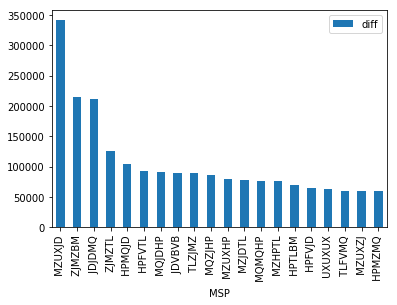

In [32]:
msp_diff.sort_values('diff', ascending=False).reset_index().head(20).plot.bar(x = 'MSP', y = 'diff');

In [30]:
msp_interest = msp_diff.sort_values('diff', ascending=False).reset_index().head(20)['MSP']

In [31]:
msp_interest

0      MZUXJD
1      ZJMZBM
2      JDJDMQ
3      ZJMZTL
4      HPMQJD
5      HPFVTL
6      MQJDHP
7      JDVBVB
8      TLZJMZ
9      MQZJHP
10     MZUXHP
11     MZJDTL
12     MQMQHP
13     MZHPTL
14     HPTLBM
15     HPFVJD
16     UXUXUX
17     TLFVMQ
18     MZUXZJ
19     HPMZMQ
Name: MSP, dtype: object

In [125]:
msp_counts[msp_counts['MSP'].isin(msp_interest)].to_csv('../clean/MSP_freq.csv', index = False)

In [33]:
corrosion = msp_counts[msp_counts['MSP'].isin(msp_interest)].query('Pre').drop('Pre', axis = 1).pivot(index = 'Job Code', columns = 'MSP', values = 'row').fillna(0.0).reset_index()

corrosion['corrosion'] = True

corrosion.drop('Job Code', axis = 1, inplace = True)

In [34]:
corrosion.head()

MSP,HPFVJD,HPFVTL,HPMQJD,HPMZMQ,HPTLBM,JDJDMQ,JDVBVB,MQJDHP,MQMQHP,MQZJHP,...,MZJDTL,MZUXHP,MZUXJD,MZUXZJ,TLFVMQ,TLZJMZ,UXUXUX,ZJMZBM,ZJMZTL,corrosion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,True
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,True
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,True
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,True
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,True


Building a dataset of non-corrosive corrective actions

In [56]:
non_corrosion_actions = maf_data[~(maf_data['Corrosion'] | maf_data['Bare Metal'] | maf_data['Corrosion Prevention Treatment'])].sample(60000, axis = 0, random_state = 35)

non_corrosion_actions["action_month"] = pd.DatetimeIndex(non_corrosion_actions['Completion Date']).month

non_corrosion_actions["action_year"] = pd.DatetimeIndex(non_corrosion_actions['Completion Date']).year

combined_data_non = non_corrosion_actions.merge(msp_data[['Aircraft', 'action_year', 'MSP', 'Flight_Mode', 'Fault Date']], how = 'left', on = ['Aircraft', 'action_year'])

combined_data_non['before_window'] = combined_data_non['Completion Date'] - pd.DateOffset(months = 1)

combined_data_non['after_window'] = combined_data_non['Completion Date'] + pd.DateOffset(months = 1)

combined_data_non = combined_data_non[(combined_data_non['Fault Date'] > combined_data_non['before_window']) & (combined_data_non['Fault Date'] < combined_data_non['after_window'])]

combined_data_non['Pre'] = combined_data_non['Fault Date'] < combined_data_non['Completion Date']

combined_data_non = combined_data_non[(combined_data_non['Fault Date'] > combined_data_non['Completion Date']) | (combined_data_non['Fault Date'] < combined_data_non['Received Date'])]

In [57]:
combined_data_non['row'] = True

non_msp_counts = combined_data_non[['Job Code', 'MSP', 'Pre', 'row']].groupby(['Job Code', 'MSP', 'Pre']).count().reset_index()

In [58]:
non_corrosion = non_msp_counts[non_msp_counts['MSP'].isin(msp_interest)].query('Pre').drop('Pre', axis = 1).pivot(index = 'Job Code', columns = 'MSP', values = 'row').fillna(0.0).reset_index()

non_corrosion['corrosion'] = False

non_corrosion.drop('Job Code', axis = 1, inplace = True)

In [59]:
non_corrosion.shape

(9260, 21)

In [60]:
corrosion.shape

(10633, 21)

In [64]:
non_corrosion.append(corrosion).to_csv('../clean/predict_corrosive.csv', index = True)